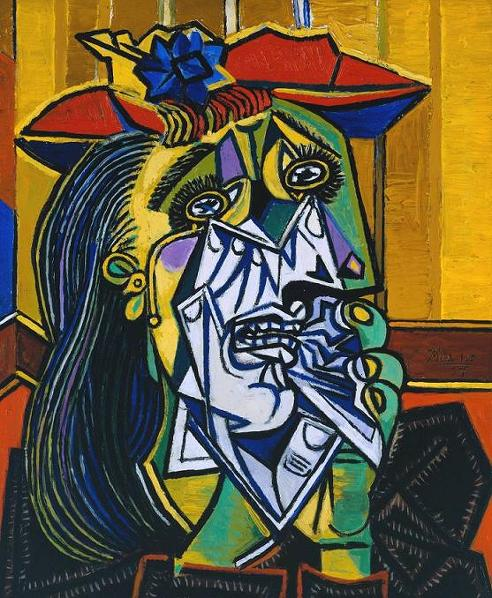

(598, 492, 3)
(3, 10, 3)


In [5]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

src = cv2.imread('/content/sample_data/sample3.jpeg')
cv2_imshow(src)
print(src.shape)

src2 = cv2.resize(src,(10,3),interpolation=cv2.INTER_LANCZOS4)
print(src2.shape)


hsv = cv2.cvtColor(src2, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv)


In [9]:
# test {"output": "ignore"}
print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi

!pip install -qU magenta

# Hack to allow python to pick up the newly-installed fluidsynth lib. 
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

print('Importing libraries and defining some helper functions...')
from google.colab import files

import magenta
import note_seq
import tensorflow

print('🎉 Done!')
print(magenta.__version__)
print(tensorflow.__version__)

Installing dependencies...
Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 5.6 MB 5.2 MB/s 
     |████████████████████████████████| 51 kB 5.6 MB/s 
     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 1.4 MB 55.3 MB/s 
     |████████████████████████████████| 1.6 MB 52.6 MB/s 
     |█████████████████

/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


🎉 Done!
2.1.3
2.7.0


In [10]:
from note_seq.protobuf import music_pb2

my_music = music_pb2.NoteSequence()

r_arr = np.zeros((3,10))  # r_arr => running time =  end_time - start_time 
#print(r_arr)

for j in range (0,3):
  for i in range (0,10):
    if (0<= h[j][i] <=25) or ( 155<= h[j][i] <= 180):   # h1
      if 128 <= s[j][i] <= 255:
        if 128 <= v[j][i] <=255:
          r_arr[j][i] = 0.2
        else:                 # 0 <= v[0][i] <= 127
          r_arr[j][i]=0.3
      else:                   # 0<= s[0][i] <=127
        if 128 <= v[j][i] <=255:
          r_arr[j][i] = 0.4
        else:                 # 0 <= v[0][i] <= 127
          r_arr[j][i]=0.5
      
    elif (26<= h[j][i] <=85):   # h2
      if 128 <= s[j][i] <= 255:
        if 128 <= v[j][i] <=255:
          r_arr[j][i] = 0.6
        else:                 
          r_arr[j][i]=0.7
      else:                   
        if 128 <= v[j][i] <=255:
          r_arr[j][i] = 0.8
        else:                 
          r_arr[j][i]=0.9

    elif(86<= h[j][i] <=154):   # h3
      if 128 <= s[j][i] <= 255:
        if 128 <= v[j][i] <=255:
          r_arr[j][i] = 1.0
        else:                 
          r_arr[j][i]=1.1
      else:                   
        if 128 <= v[j][i] <=255:
          r_arr[j][i] = 1.2
        else:                 
          r_arr[j][i]=1.3
      

In [11]:
tp_arr = [255,226,197,168,139,110,81,52,23] #matching s,v about pitch 
p_arr = np.zeros((3,10))  #pitch array

for p in range(0,3):
  for k in range (0,10):
    for m in range(0,9):   #s:채도
      for n in range(0,9):  #v:명도
        if (tp_arr[m]-28) <= s[p][k] <= tp_arr[m]:
            if (tp_arr[n]-28) <= v[p][k] <= tp_arr[n]:
              p_arr[p][k]= 106 - ((m+1)*(n+1))


In [12]:
p_arr = np.int64(p_arr) #type 변환

start = 0.0
for i in range (0,10):
  my_music.notes.add( pitch = p_arr[0][i], start_time= start , end_time= start + r_arr[0][i], program=0, velocity=80)
  start = start +r_arr[0][i]

start = 0.0
for i in range (0,10):
  my_music.notes.add( pitch = p_arr[1][i], start_time= start , end_time= start + r_arr[1][i] ,program=0, velocity=80)
  start = start +r_arr[1][i]

start = 0.0
for i in range (0,10):
  my_music.notes.add( pitch = p_arr[2][i], start_time= start , end_time= start + r_arr[2][i] ,program=0, velocity=80)
  start = start +r_arr[2][i]

my_music.tempos.add(qpm=60);

# This is a colab utility method that visualizes a NoteSequence.
note_seq.plot_sequence(my_music)

# This is a colab utility method that plays a NoteSequence.
note_seq.play_sequence(my_music,synth=note_seq.fluidsynth)

In [ ]:
# This creates a file called `drums_sample_output.mid`, containing the drums solo we've been using.
note_seq.sequence_proto_to_midi_file(my_music, 'my_music.mid')

# This is a colab utility method to download that file. In your Python script, you 
# would just write it to disk.
files.download('my_music.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
print('Downloading model bundle. This will take less than a minute...')
note_seq.notebook_utils.download_bundle('basic_rnn.mag', '/content/')

# Import dependencies.
from magenta.models.melody_rnn import melody_rnn_sequence_generator
from magenta.models.shared import sequence_generator_bundle
from note_seq.protobuf import generator_pb2
from note_seq.protobuf import music_pb2

# Initialize the model.
print("Initializing Melody RNN...")
bundle = sequence_generator_bundle.read_bundle_file('/content/basic_rnn.mag')
generator_map = melody_rnn_sequence_generator.get_generator_map()
melody_rnn = generator_map['basic_rnn'](checkpoint=None, bundle=bundle)
melody_rnn.initialize()

print('🎉 Done!')

Initializing Melody RNN...
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from /tmp/tmp29dcwimv/model.ckpt
🎉 Done!


In [14]:
# Model options. Change these to get different generated sequences! 

input_sequence = my_music # change this to teapot if you want
num_steps = 128 # change this for shorter or longer sequences
temperature = 2.0 # the higher the temperature the more random the sequence.

# Set the start time to begin on the next step after the last note ends.
last_end_time = (max(n.end_time for n in input_sequence.notes)
                  if input_sequence.notes else 0)
qpm = input_sequence.tempos[0].qpm 
seconds_per_step = 60.0 / qpm / melody_rnn.steps_per_quarter
total_seconds = num_steps * seconds_per_step

generator_options = generator_pb2.GeneratorOptions()
generator_options.args['temperature'].float_value = temperature
generate_section = generator_options.generate_sections.add(
  start_time=last_end_time + seconds_per_step,
  end_time=total_seconds)

# Ask the model to continue the sequence.
sequence = melody_rnn.generate(input_sequence, generator_options)

note_seq.plot_sequence(sequence)
note_seq.play_sequence(sequence, synth=note_seq.fluidsynth)


INFO:tensorflow:Beam search yields sequence with log-likelihood: -398.064911 


In [ ]:
# This creates a file called `drums_sample_output.mid`, containing the drums solo we've been using.
note_seq.sequence_proto_to_midi_file(sequence, 'my_music.mid')

# This is a colab utility method to download that file. In your Python script, you 
# would just write it to disk.
files.download('my_music.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>